In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [29]:
# Cargar dataset de features
df = pd.read_csv('data/BTC_5m_features.csv')

# Definir las features utilizadas
features = [
    'log_return', 'pct_change', 'rsi', 'ema_12', 'ema_26',
    'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_lower', 'bb_width',
    'returns_mean_5', 'returns_std_5', 'returns_mean_20', 'returns_std_20',
    'ema_diff', 'rsi_macd_ratio', 'bb_position', 'rsi_overbought', 'rsi_oversold',
    'macd_cross', 'volatility', 'adx', 'atr', 'vol_ratio'
]

# Cargar modelos
model_xgb = joblib.load('models/xgb_btc_model.pkl')
model_lstm = load_model('models/lstm_btc_model.keras')  # ✅ Actualizado al nuevo formato


In [30]:
train_size = 0.8
split_idx = int(len(df) * train_size)

X_test_xgb = df[features].iloc[split_idx:]
df_test = df.iloc[split_idx:].copy()

# Escalado para LSTM
scaled_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(df[['close']].values)
sequence_length = 60
X_test_lstm = []

for i in range(split_idx + sequence_length, len(scaled_data)):
    X_test_lstm.append(scaled_data[i-sequence_length:i, 0])

X_test_lstm = np.array(X_test_lstm).reshape((-1, sequence_length, 1))
df_test = df_test.iloc[sequence_length:]


In [31]:
threshold = 0.7  # Umbral de confianza

# Probabilidades de los modelos
proba_xgb = model_xgb.predict_proba(X_test_xgb.iloc[sequence_length:])[:, 1]
proba_lstm = model_lstm.predict(X_test_lstm).flatten()

# Ensemble: promedio de probabilidades
ensemble_proba = (proba_xgb + proba_lstm) / 2

# Predicción final
df_test['prediction'] = (ensemble_proba > threshold).astype(int)

# Revisión rápida
df_test[['timestamp', 'close', 'prediction']].head()


791/791 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


,timestamp,close,prediction
101495,2024-12-22 14:25:00,95848.01,0
101496,2024-12-22 14:30:00,95704.02,0
101497,2024-12-22 14:35:00,95755.09,0
101498,2024-12-22 14:40:00,95822.81,0
101499,2024-12-22 14:45:00,96026.03,0


In [32]:
# Generar el target si no existe
if 'target' not in df.columns:
    df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

# Variables reales y predichas
y_test_true = df['target'].iloc[split_idx + sequence_length:]
y_test_pred = df_test['prediction']

# Métricas de evaluación
accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred)
recall = recall_score(y_test_true, y_test_pred)
f1 = f1_score(y_test_true, y_test_pred)
cm = confusion_matrix(y_test_true, y_test_pred)

print("📊 Evaluación del Ensemble XGBoost + LSTM:")
print(f"✅ Accuracy:  {accuracy:.2f}")
print(f"✅ Precision: {precision:.2f}")
print(f"✅ Recall:    {recall:.2f}")
print(f"✅ F1 Score:  {f1:.2f}")
print("\nMatriz de Confusión:")
print(cm)


📊 Evaluación del Ensemble XGBoost + LSTM:
✅ Accuracy:  0.50
✅ Precision: 0.00
✅ Recall:    0.00
✅ F1 Score:  0.00

Matriz de Confusión:
[[12644     0]
 [12655     0]]


/opt/anaconda3/envs/tf2.11/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Parámetros de la simulación
capital_inicial = 10000
capital = capital_inicial
btc_holdings = 0
trading_fee = 0.001

capital_history = []
btc_holdings_history = []
actions = []

stop_trading = False
max_loss_percentage = 5

# Backtest loop
for idx, row in df_test.iterrows():
    signal = row['prediction']
    price = row['close']

    stop_loss = price * (1 - 1.5 / 100)
    take_profit = price * (1 + 3.0 / 100)

    if stop_trading:
        actions.append('NO TRADE - STOP RISK')
        capital_history.append(capital + btc_holdings * price)
        btc_holdings_history.append(btc_holdings)
        continue

    # Ejecutar BUY
    if signal == 1 and capital > 0:
        btc_bought = (capital * (1 - trading_fee)) / price
        btc_holdings += btc_bought
        capital = 0
        actions.append('BUY')

    # Ejecutar SELL
    elif signal == 0 and btc_holdings > 0:
        capital = btc_holdings * price * (1 - trading_fee)
        btc_holdings = 0
        actions.append('SELL')

    else:
        actions.append('HOLD')

    # Evaluación de pérdidas y STOP
    unrealized_capital = btc_holdings * price if btc_holdings > 0 else capital
    daily_losses = ((unrealized_capital - capital_inicial) / capital_inicial) * 100

    if daily_losses <= -max_loss_percentage:
        stop_trading = True
        print(f"🚨 STOP TRADING activado: pérdida de {daily_losses:.2f}%")

    total_capital = capital + btc_holdings * price
    capital_history.append(total_capital)
    btc_holdings_history.append(btc_holdings)


In [34]:
df_test['capital'] = capital_history
df_test['btc_holdings'] = btc_holdings_history
df_test['action'] = actions


In [35]:
final_capital = capital_history[-1]
roi = ((final_capital - capital_inicial) / capital_inicial) * 100

print(f"✅ Capital Inicial: ${capital_inicial:,.2f}")
print(f"✅ Capital Final: ${final_capital:,.2f}")
print(f"✅ ROI Estrategia: {roi:.2f}%")


✅ Capital Inicial: $10,000.00
✅ Capital Final: $10,000.00
✅ ROI Estrategia: 0.00%


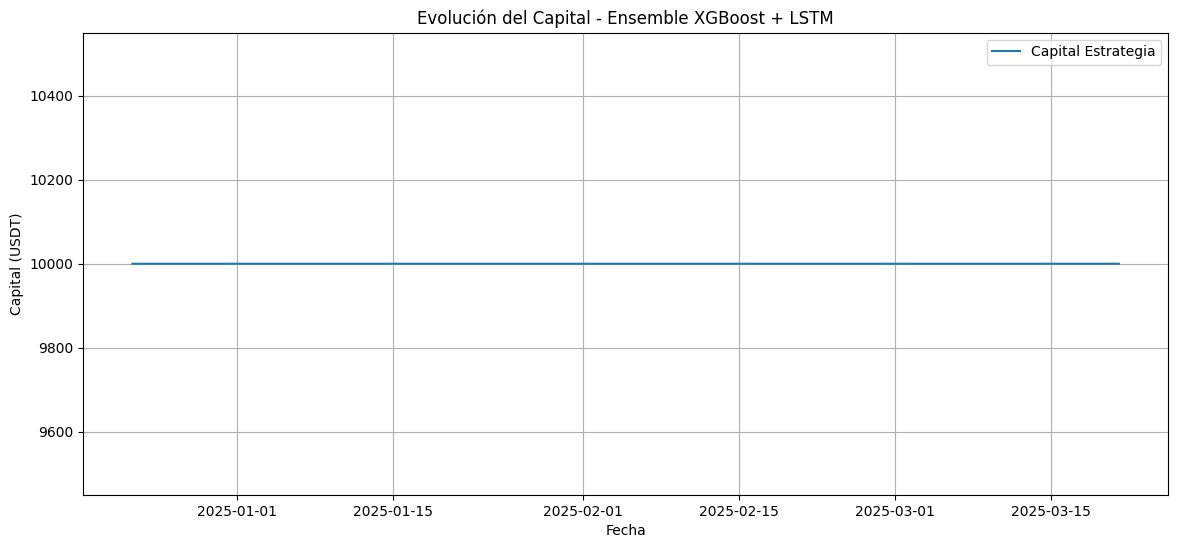

In [36]:
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

plt.figure(figsize=(14, 6))
plt.plot(df_test['timestamp'], capital_history, label='Capital Estrategia')
plt.title('Evolución del Capital - Ensemble XGBoost + LSTM')
plt.xlabel('Fecha')
plt.ylabel('Capital (USDT)')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
df_test.to_csv('data/BTC_backtest_ensemble_results.csv', index=False)
print("✅ Resultados guardados en 'data/BTC_backtest_ensemble_results.csv'")


✅ Resultados guardados en 'data/BTC_backtest_ensemble_results.csv'
